
## План анализа: <br />
1. **Знакомство с данными**
   1. Загрузка и оценка первых строк дата сета
   2. Постройка гистограмм данных
   3. Оценка количества данных и типов
   4. Оценка количества пропусков
   5. Анализ типов данных
2. **Предобработка данных**
   1. Поиск и обработка пропусков
   2. Обработка типов данных
   3. Поиск и обработка явных и неявных дубликатов
   4. Отброс аномально высоких и низких значений
3. **Анализ взаимосвязей**
4. **Выполнение дополнительных заданий**
    </list>

## Начальная подготовка
### Получение данных, общий анализ

In [142]:
#pip install phik

In [143]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import phik
from phik.report import plot_correlation_matrix
from phik import report
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None 

### Дополнительные параметры датафрейма

In [144]:
# df = pd.read_csv('./datasets/real_estate_data.csv', sep = '\t')
df = pd.read_csv('../datasets/real_estate_data.csv', sep = '\t')
df.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [145]:
display(df.info())
len_df_start = len(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

None

In [207]:
# check
# пропущенные значения бары

def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind= 'barh', figsize=(19,6), rot = 0, legend = False, fontsize = 16)
            .set_title('Доля пропущенных значений' + "\n", fontsize = 22, color = 'SteelBlue')    
        );    
    except:
        print('пропусков не осталось (%):) ')

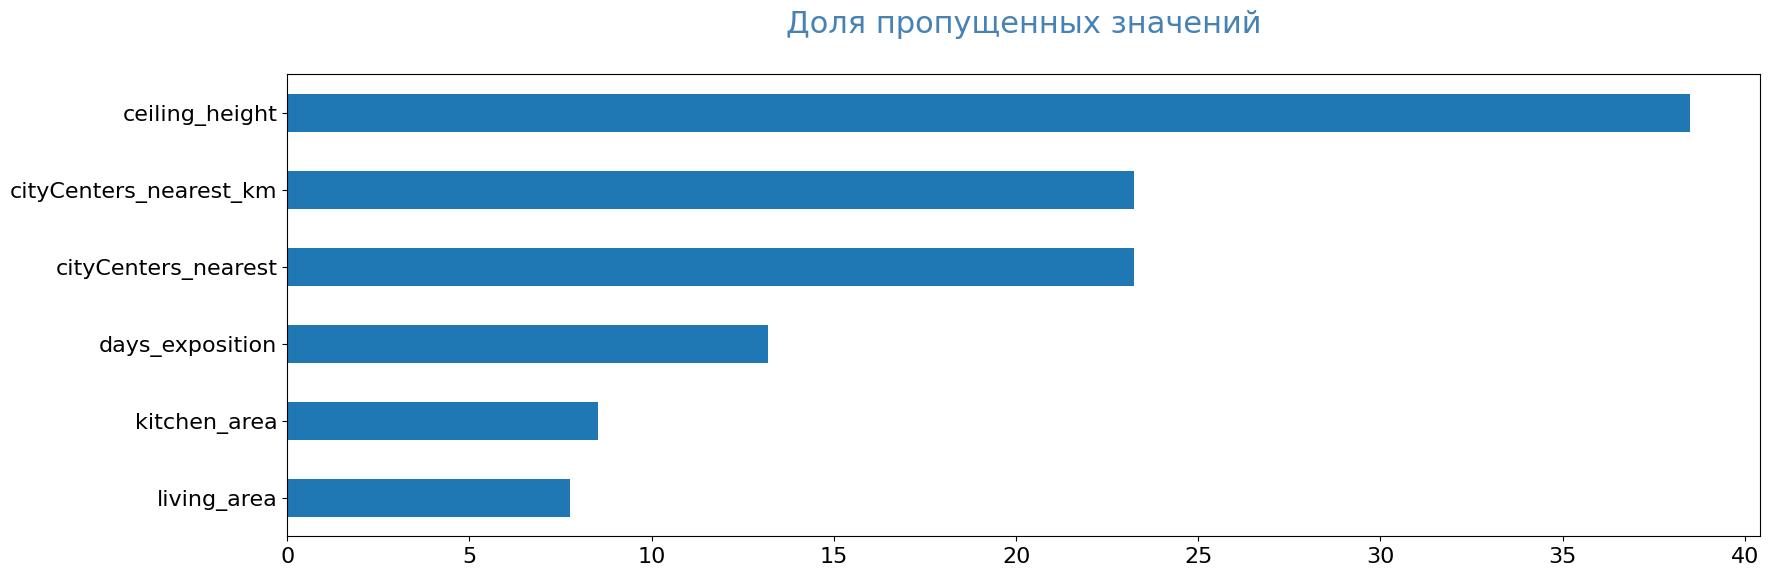

In [208]:
pass_value_barh(df)

In [148]:
print(df.isna().sum()
     .to_frame()
     .rename(columns = {0:'Na'})
     .query('Na > 0')
     .sort_values('Na',ascending = False))

                        Na
is_apartment         20924
parks_nearest        15620
ponds_nearest        14589
balcony              11519
ceiling_height        9195
airports_nearest      5542
cityCenters_nearest   5519
parks_around3000      5518
ponds_around3000      5518
days_exposition       3181
kitchen_area          2278
living_area           1903
floors_total            86
locality_name           49


Предварительные выводы по столбцам, требущим обработки отсутствующих значений
1. locality_name, floors_total можем сразу отсечь, т.к. их доля не значительна
2. living_area kitchen_area ceiling_height попробуем заполнить из других параметров
3. Остальные столбцы не потребуются для анализа, во-вторых отсутствие данных может означать отсутствие балкона/пруда рядом


### Гистограммы

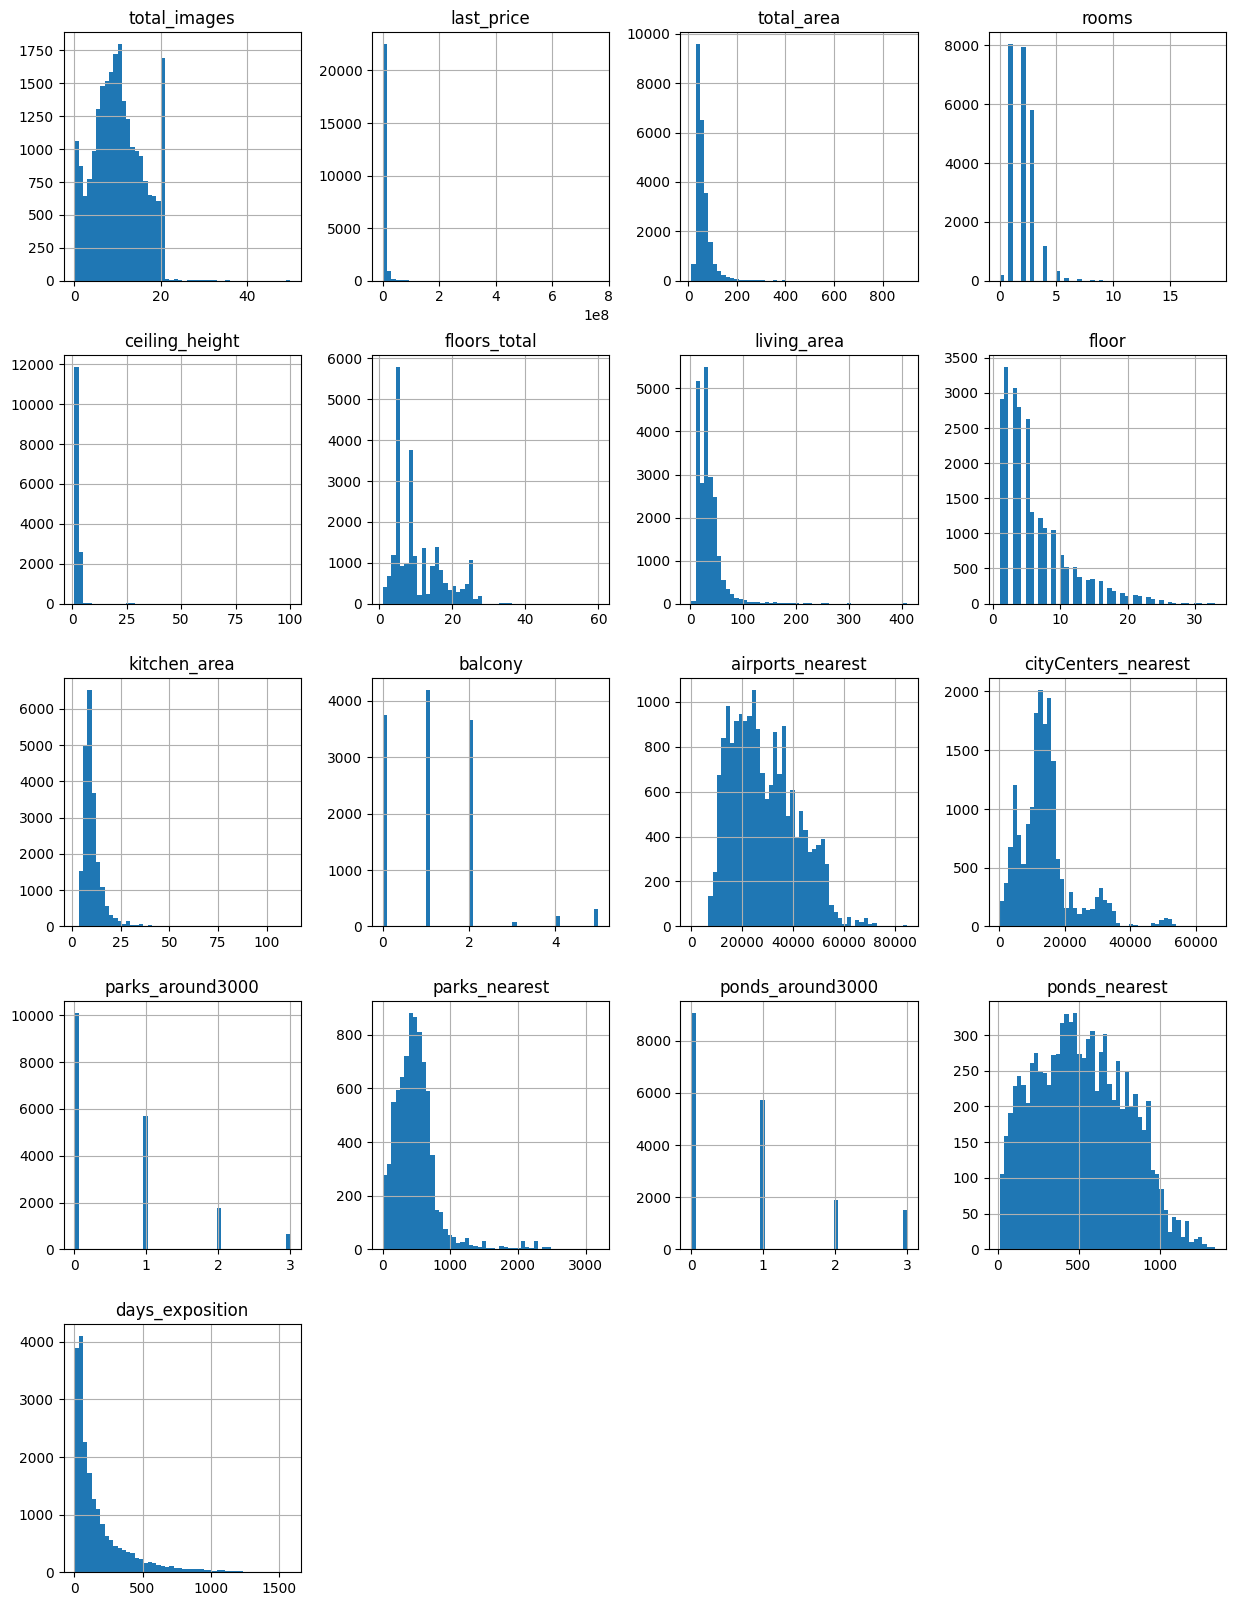

In [149]:
df.hist(figsize=(15, 20), bins = 50)
plt.show()

In [150]:
#Для анализа нас интересуют следующие параметры:
params = ['rooms', 
          'total_area', 
          'ceiling_height', 
          'days_exposition', 
          'last_price', 
          'living_area', 
          'kitchen_area', 
          'floor', 
          'floors_total']
df[params].describe().append(df[params].quantile([0.02,0.98])).style.format("{:,.1f}")


,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"23,699.0","23,699.0","14,504.0","20,518.0","23,699.0","21,796.0","21,421.0","23,699.0","23,613.0"
mean,2.1,60.3,2.8,180.9,"6,541,548.8",34.5,10.6,5.9,10.7
std,1.1,35.7,1.3,219.7,"10,887,013.3",22.0,5.9,4.9,6.6
min,0.0,12.0,1.0,1.0,"12,190.0",2.0,1.3,1.0,1.0
25%,1.0,40.0,2.5,45.0,"3,400,000.0",18.6,7.0,2.0,5.0
50%,2.0,52.0,2.6,95.0,"4,650,000.0",30.0,9.1,4.0,9.0
75%,3.0,69.9,2.8,232.0,"6,800,000.0",42.3,12.0,8.0,16.0
max,19.0,900.0,100.0,"1,580.0","763,000,000.0",409.7,112.0,33.0,60.0
0.020000,1.0,28.5,2.5,5.0,"1,300,000.0",14.0,5.0,1.0,3.0
0.980000,5.0,159.0,3.5,900.0,"25,000,000.0",94.4,28.0,21.0,25.0


### Выводы части ч.1
1. Столбцы, требующие проверки/корректировки типа данных:
    * floors_total
    * first_day_exposition
    * is_apartment
    * balcony
    * parks_around3000
    * ponds_around3000
2. Столбцы, требующие обработки пропусков:
    * is_apartment         20924
    * parks_nearest        15620
    * ponds_nearest        14589
    * balcony              11519
    * ceiling_height        9195
    * airports_nearest      5542
    * cityCenters_nearest   5519
    * parks_around3000      5518
    * ponds_around3000      5518
    * days_exposition       3181
    * kitchen_area          2278
    * living_area           1903
    * floors_total            86
    * locality_name           49
3. Также из таблицы выше видно, что есть аномально высокие и аномально низкие значения некоторых параметров. К ним мы вернемся после очистки датафрейма и заполнения значений, которые можно рассчитать

## Предобработка данных
### Изменение типов данных и заполнение NaN

In [151]:
print ('Количество строк до удаления na:',len(df))
df=df.dropna(subset=['floors_total','locality_name'])
print ('Количество строк после удаления na:',len(df))

Количество строк до удаления na: 23699
Количество строк после удаления na: 23565


In [152]:
df['first_day_exposition']=pd.to_datetime(df['first_day_exposition'],format='%Y-%m-%dT%H:%M:%S')
df['is_apartment']=df['is_apartment'].astype(bool)
#Cохраним название столбцов, где отсутствие данных скорее всего будет означать 0.
fillzero_cols = ['parks_around3000',
                 'ponds_around3000',
                 'balcony',
                 'airports_nearest',
                 'parks_nearest',
                 'ponds_nearest']
df.loc[:,fillzero_cols]=df.loc[:,fillzero_cols].fillna(0).astype(int)
df.dtypes

total_images                     int64
last_price                     float64
total_area                     float64
first_day_exposition    datetime64[ns]
rooms                            int64
ceiling_height                 float64
floors_total                   float64
living_area                    float64
floor                            int64
is_apartment                      bool
studio                            bool
open_plan                         bool
kitchen_area                   float64
balcony                          int32
locality_name                   object
airports_nearest                 int32
cityCenters_nearest            float64
parks_around3000                 int32
parks_nearest                    int32
ponds_around3000                 int32
ponds_nearest                    int32
days_exposition                float64
dtype: object

In [153]:
df.isna().sum()[df.isna().sum()>0]

ceiling_height         9084
living_area            1865
kitchen_area           2222
cityCenters_nearest    5501
days_exposition        3171
dtype: int64

In [154]:
df.corr()['living_area']['total_area']

0.9397711143610353

Жилая площадь коррелирует с общей площадью, найдем коэффициент:

In [155]:
koef = df[df['living_area'] > 0]['living_area'].sum()/df[df['living_area'] > 0]['total_area'].sum()
print(koef)

0.5736591515482824


В среднем размер жилой площади составляет 57% от общей площади заполним жилую площадь такими значениями

In [156]:
df_copy = df[['living_area','kitchen_area','total_area']]
df_copy['living_area'] = df_copy['living_area'].fillna(df_copy['total_area']*koef)
# Проверим есть ли строки, в которых суммарная площадь меньше living + kitchen
print ('Количество аномальных данных:', len(df_copy[df_copy['total_area']*0.9<(df_copy['living_area']+df_copy['kitchen_area'])]))


Количество аномальных данных: 500


In [157]:
len(df)

23565

### Удаление неявных дубликатов

In [158]:
#Удаляем неявные дубликаты из названий населенных пунктов
bad_words = [
'поселок городского типа имени ',
'садоводческое некоммерческое товарищество ',
'посёлок городского типа имени ',
'посёлок городского типа имени ',
'поселок городского типа ',
'посёлок городского типа ',
'посёлок при железнодорожной станции ',
'городской поселок ',
'посёлок станции ',
'городской посёлок ', 
'садовое товарищество ', 
'коттеджный посёлок ', 
'посёлок коттеджный ', 
'поселок коттеджный ', 
'коттеджный поселок ', 
'поселок станции ',
'при железнодорожной станции ',
'поселок ',
'городской ',
'деревня ',
'посёлок ',
'поселок ',
'село ',
'имени ', 
'станции ',]

def locality_clean(x):
    
    for wrd in bad_words:
        if str(wrd) in str(x): return(x.replace(wrd,''))
    return(x)    

df['short_locality_name']=df['locality_name'].apply(locality_clean)
print('Кол-во уникальных населенных пунктов до преобразования: ', len(df['locality_name'].unique()))
print('Кол-во уникальных населенных пунктов после преобразования: ',len(df['short_locality_name'].sort_values().unique()))
#display(df_good['locality_name'].sort_values().unique())
#display(df_good['short_locality_name'].sort_values().unique())
print(len(df))

Кол-во уникальных населенных пунктов до преобразования:  364
Кол-во уникальных населенных пунктов после преобразования:  305
23565


### Чистка аномалий

In [159]:
len(df)

23565

In [160]:
params = ['rooms', 
          'total_area', 
          'ceiling_height', 
          'days_exposition', 
          'last_price', 
          'living_area', 
          'kitchen_area', 
          'floor', 
          'floors_total']
df[params].describe().append(df[params].quantile([0.02,0.95,0.99])).style.format("{:,.1f}")


,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"23,565.0","23,565.0","14,481.0","20,394.0","23,565.0","21,700.0","21,343.0","23,565.0","23,565.0"
mean,2.1,60.3,2.8,180.7,"6,540,058.3",34.5,10.6,5.9,10.7
std,1.1,35.7,1.3,219.7,"10,910,934.7",22.0,5.9,4.9,6.6
min,0.0,12.0,1.0,1.0,"12,190.0",2.0,1.3,1.0,1.0
25%,1.0,40.0,2.5,45.0,"3,400,000.0",18.6,7.0,2.0,5.0
50%,2.0,52.0,2.6,95.0,"4,646,000.0",30.0,9.1,4.0,9.0
75%,3.0,69.7,2.8,231.0,"6,790,000.0",42.3,12.0,8.0,16.0
max,19.0,900.0,100.0,"1,580.0","763,000,000.0",409.7,112.0,33.0,60.0
0.020000,1.0,28.5,2.5,5.0,"1,300,000.0",14.0,5.0,1.0,3.0
0.950000,4.0,116.0,3.3,647.3,"15,300,000.0",69.0,20.0,16.0,25.0


In [161]:
df[params].isna().sum()[df[params].isna().sum()>0] #Чтобы не забыть выведем столбцы, где остались na

ceiling_height     9084
days_exposition    3171
living_area        1865
kitchen_area       2222
dtype: int64

In [162]:
len(df)

23565

#### check nan

In [163]:
# check
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23565 non-null  int64         
 1   last_price            23565 non-null  float64       
 2   total_area            23565 non-null  float64       
 3   first_day_exposition  23565 non-null  datetime64[ns]
 4   rooms                 23565 non-null  int64         
 5   ceiling_height        14481 non-null  float64       
 6   floors_total          23565 non-null  float64       
 7   living_area           21700 non-null  float64       
 8   floor                 23565 non-null  int64         
 9   is_apartment          23565 non-null  bool          
 10  studio                23565 non-null  bool          
 11  open_plan             23565 non-null  bool          
 12  kitchen_area          21343 non-null  float64       
 13  balcony         

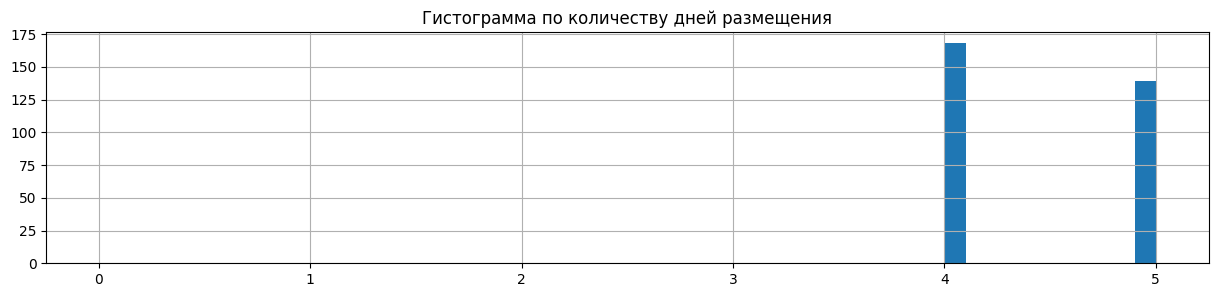

In [209]:
# check
df.hist(column = 'days_exposition', bins = 50, figsize = (15,3), range = (0,5))
plt.title('Гистограмма по количеству дней размещения')
plt.show()

In [165]:
params = ['rooms', 
          'total_area', 
          'ceiling_height', 
          'days_exposition', 
          'last_price', 
          'living_area', 
          'kitchen_area', 
          'floor', 
          'floors_total']
df[params].describe().append(df[params].quantile([0.01,0.99])).style.format("{:,.1f}")


,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"23,565.0","23,565.0","14,481.0","20,394.0","23,565.0","21,700.0","21,343.0","23,565.0","23,565.0"
mean,2.1,60.3,2.8,180.7,"6,540,058.3",34.5,10.6,5.9,10.7
std,1.1,35.7,1.3,219.7,"10,910,934.7",22.0,5.9,4.9,6.6
min,0.0,12.0,1.0,1.0,"12,190.0",2.0,1.3,1.0,1.0
25%,1.0,40.0,2.5,45.0,"3,400,000.0",18.6,7.0,2.0,5.0
50%,2.0,52.0,2.6,95.0,"4,646,000.0",30.0,9.1,4.0,9.0
75%,3.0,69.7,2.8,231.0,"6,790,000.0",42.3,12.0,8.0,16.0
max,19.0,900.0,100.0,"1,580.0","763,000,000.0",409.7,112.0,33.0,60.0
0.010000,1.0,25.3,2.5,4.0,"1,000,000.0",13.0,5.0,1.0,2.0
0.990000,5.0,197.5,3.8,"1,067.1","36,000,000.0",120.0,35.0,23.0,26.0


In [166]:
len(df)

23565

In [167]:
df[params].describe().append(df[params].quantile([0.01,0.95,0.99])).style.format("{:,.1f}")

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"23,565.0","23,565.0","14,481.0","20,394.0","23,565.0","21,700.0","21,343.0","23,565.0","23,565.0"
mean,2.1,60.3,2.8,180.7,"6,540,058.3",34.5,10.6,5.9,10.7
std,1.1,35.7,1.3,219.7,"10,910,934.7",22.0,5.9,4.9,6.6
min,0.0,12.0,1.0,1.0,"12,190.0",2.0,1.3,1.0,1.0
25%,1.0,40.0,2.5,45.0,"3,400,000.0",18.6,7.0,2.0,5.0
50%,2.0,52.0,2.6,95.0,"4,646,000.0",30.0,9.1,4.0,9.0
75%,3.0,69.7,2.8,231.0,"6,790,000.0",42.3,12.0,8.0,16.0
max,19.0,900.0,100.0,"1,580.0","763,000,000.0",409.7,112.0,33.0,60.0
0.010000,1.0,25.3,2.5,4.0,"1,000,000.0",13.0,5.0,1.0,2.0
0.950000,4.0,116.0,3.3,647.3,"15,300,000.0",69.0,20.0,16.0,25.0


In [168]:
df_test = df[(df['rooms']<=6)&(df['rooms']>=1)&
       (df['total_area']>=22)&(df['total_area']<230)&
       ((df['ceiling_height'].isna())|((df['ceiling_height']>=1.5)&(df['ceiling_height']<5)))&
       ((df['days_exposition'].isna())|((df['days_exposition']>=4)&(df['days_exposition']<1000)))&
        (df['last_price']>=1000000)&(df['last_price']<=23000000)&
        ((df['living_area'].isna())|((df['living_area']>=10)&(df['living_area']<150)))&
        ((df['kitchen_area'].isna())|((df['kitchen_area']>=4)&(df['kitchen_area']<30)))&
        (df['floor']>=1)&(df['floor']<30)&
        ((df['floors_total'].isna())|((df['floors_total']>=2)&(df['floors_total']<30)))]

print ('Изначальное количество строк в датафрейме:', len_df_start)
print ('Количество строк после преобразования:', len(df_test))
print ('Доля исключенных строк', 1-len(df_test)/len_df_start)
df_test[params].describe().append(df_test[params].quantile([0.01,0.95,0.99])).style.format("{:,.1f}")

Изначальное количество строк в датафрейме: 23699
Количество строк после преобразования: 21753
Доля исключенных строк 0.08211316933203938


,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"21,753.0","21,753.0","13,382.0","18,884.0","21,753.0","20,068.0","19,896.0","21,753.0","21,753.0"
mean,2.0,56.7,2.7,166.8,"5,476,993.1",32.6,9.9,5.9,10.7
std,1.0,23.5,0.3,186.0,"3,270,281.5",16.1,3.8,4.9,6.5
min,1.0,22.0,2.0,4.0,"1,000,000.0",10.0,4.0,1.0,2.0
25%,1.0,40.0,2.5,45.0,"3,450,000.0",18.5,7.0,2.0,5.0
50%,2.0,51.1,2.6,93.0,"4,600,000.0",30.0,9.0,4.0,9.0
75%,3.0,67.1,2.8,219.0,"6,500,000.0",41.7,11.5,8.0,16.0
max,6.0,220.0,4.8,999.0,"23,000,000.0",147.2,29.9,27.0,29.0
0.010000,1.0,28.0,2.5,5.0,"1,300,000.0",13.4,5.0,1.0,2.0
0.950000,4.0,100.3,3.2,579.0,"12,304,854.6",61.8,17.1,16.0,25.0


In [169]:
df=df_test

In [170]:
# check

# Показатели о кол-ве объявлений в датасете, минимальных и максимальных значениях 
# в выбранных параметрах о продаже квартир
# сырые данные

data = df.copy()
(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
          'floor', 'floors_total']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"21,753.00","21,753.00","13,382.00","18,884.00","21,753.00","20,068.00","19,896.00","21,753.00","21,753.00"
min,1.00,22.00,2.00,4.00,"1,000,000.00",10.00,4.00,1.00,2.00
max,6.00,220.00,4.80,999.00,"23,000,000.00",147.20,29.90,27.00,29.00


In [171]:
# check
data.rooms.value_counts().to_frame()

,rooms
1,7674
2,7472
3,5367
4,969
5,216
6,55


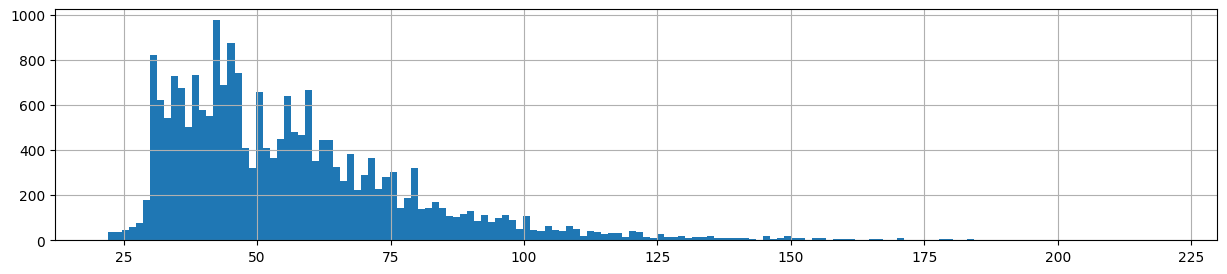

In [172]:
# check
data.total_area.hist(bins = 150, figsize = (15,3));

<div class="alert alert-success">
<font size="4", color= "seagreen"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />т.е. все квартиры более 250-ти квадратных метров можно считать редкостями
        
особенно это заметно на втором графике, где мы подробно рассматриваем промежуток от 180 кв. метров до 500

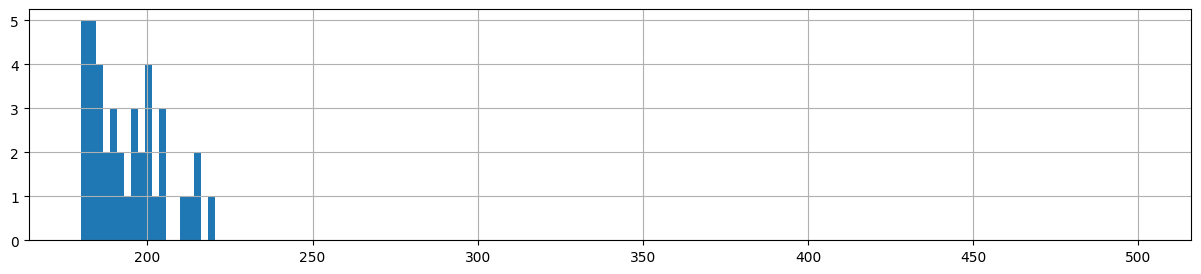

In [173]:
# check
data.total_area.hist(bins = 150, figsize = (15,3), range = (180,500));

In [174]:
# check

# Значения параметров объектов недвижимости на разных квантилях

(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  
        'kitchen_area', 'floor',   'floors_total']]
    .quantile([0.01, .5, .90, .9976])  
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
0.010000,1.00,28.00,2.50,5.00,"1,300,000.00",13.36,5.00,1.00,2.00
0.500000,2.00,51.10,2.65,93.00,"4,600,000.00",30.00,9.00,4.00,9.00
0.900000,3.00,86.08,3.00,429.00,"9,500,000.00",52.00,14.90,13.00,22.00
0.997600,6.00,174.23,4.00,961.00,"21,600,000.00",112.00,27.90,25.00,27.00


### Посчитайте и добавьте в таблицу новые столбцы

In [175]:
df['price_1m']=df['last_price']/df['total_area']
df['first_day_exposition']=pd.to_datetime(df['first_day_exposition'],format='%Y-%m-%dT%H:%M:%S') #Меняем тип данных на дату
df['exposition_month_week_day'] = df['first_day_exposition'].dt.day_of_week
df['exposition_month'] = df['first_day_exposition'].dt.month
df['exposition_year'] = df['first_day_exposition'].dt.year
def last_floor(row):
    if (row['floor'] == row['floors_total']) and (row['floors_total']!= 1): return('last')
    elif row['floor'] == 1: return('first')
    else: return ('other')
df['floor_type'] = df.apply(last_floor, axis=1)

import numpy #Нам потребуется округление вверх, т.к расстояние 0 до центра мы хотим видеть как 1
df['cityCenters_nearest_km'] = numpy.ceil(df['cityCenters_nearest']/1000)
df.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,short_locality_name,price_1m,exposition_month_week_day,exposition_month,exposition_year,floor_type,cityCenters_nearest_km
0,20,13000000.0,108.0,2019-03-07,3,2.7,16.0,51.0,8,True,...,2,755,NaN,Санкт-Петербург,120370.370370,3,3,2019,other,17.0
1,7,3350000.0,40.4,2018-12-04,1,NaN,11.0,18.6,1,True,...,0,0,81.0,Шушары,82920.792079,1,12,2018,first,19.0
2,10,5196000.0,56.0,2015-08-20,2,NaN,5.0,34.3,4,True,...,2,574,558.0,Санкт-Петербург,92785.714286,3,8,2015,other,14.0
5,10,2890000.0,30.4,2018-09-10,1,NaN,12.0,14.4,5,True,...,0,0,55.0,Янино-1,95065.789474,0,9,2018,other,NaN
6,6,3700000.0,37.3,2017-11-02,1,NaN,26.0,10.6,6,True,...,0,0,155.0,Парголово,99195.710456,3,11,2017,other,20.0


### Заполнение синтетических параметров

In [176]:
df[params].isna().sum()[df[params].isna().sum()>0] #Осталось дозаполнить пропуски с пропусками

ceiling_height     8371
days_exposition    2869
living_area        1685
kitchen_area       1857
dtype: int64

In [177]:
df['area_group']=pd.cut(df['total_area'],bins = 8,labels = range(8)).astype(str) #Жилая и кухонная площади коррелируют с total, поэтому сделаем группы
df['area_group'].value_counts()

0    9254
1    7976
2    3156
3     928
4     248
5     133
6      40
7      18
Name: area_group, dtype: int64

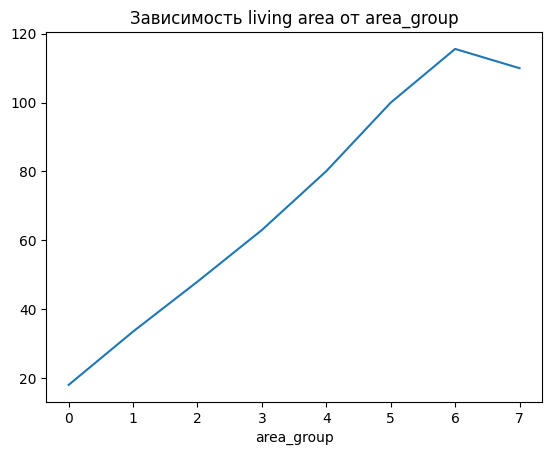

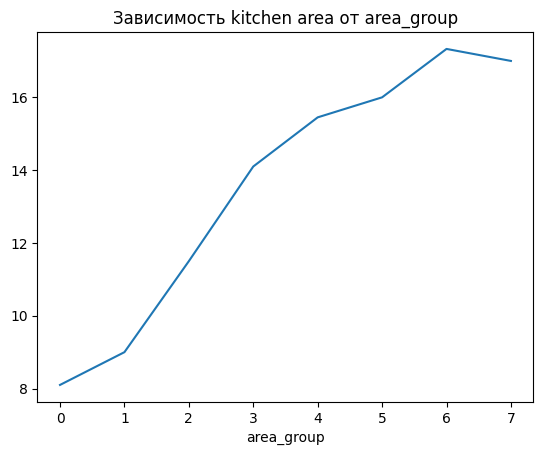

In [178]:
df.groupby('area_group')['living_area'].median().plot()
plt.title('Зависимость living area от area_group')
plt.show()
df.groupby('area_group')['kitchen_area'].median().plot()
plt.title('Зависимость kitchen area от area_group')
plt.show()

Проверяем гипотезу о том, что высота потолка зависит от ценового сегмента

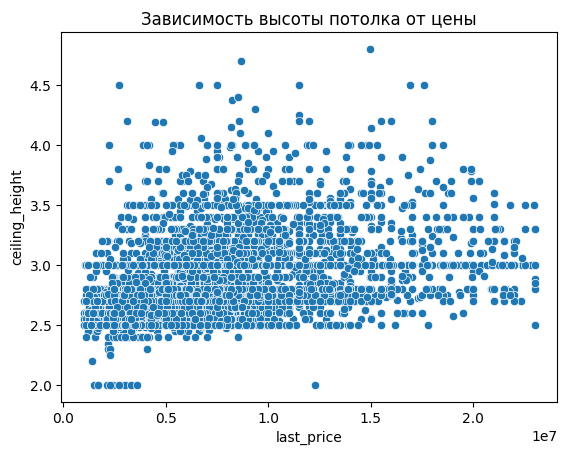

In [179]:
df_ceils=df[df['ceiling_height']>0]
sns.scatterplot(x=df_ceils['last_price'],y=df_ceils['ceiling_height'])
plt.title('Зависимость высоты потолка от цены')
plt.show()



Зависимость не сильная, поэтому не будем заполнять пропуски

### Выводы части 2
* Нам удалось подготовить датафрейм для анализа.
* Мы выяснили, что жилая площадь, зависит от общей площади, и заполнили пропуски.
* Аналогично заполнили kitchen_data
* Мы удалили неявные дубликаты в названиях городов.
* Изменили типы данных
* Создали дополнительные столбцы для сегментации


## Исследовательский анализ
### Диаграммы новой таблицы
#### Общая площадь

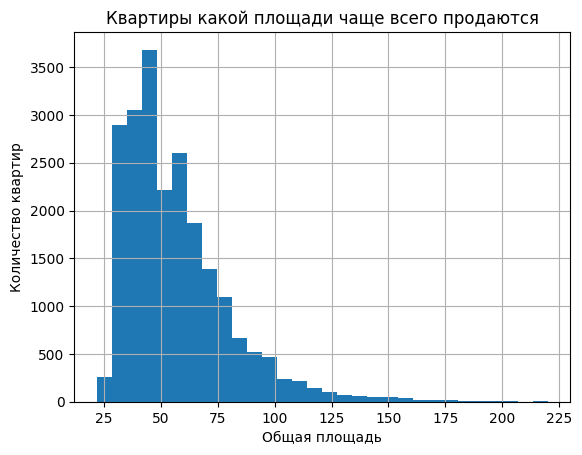

Медиана: 51.1


In [180]:
ax = df['total_area'].hist(bins = 30)
ax.set_xlabel("Общая площадь")
ax.set_ylabel("Количество квартир")
ax.set_title("Квартиры какой площади чаще всего продаются")
plt.show()
print('Медиана:',df['total_area'].apply('median'))

Распределение имеет вид Распределения Пуассона, что говорит о том, что распределение близко к нормальному.
Медиана составила 52 метра, что говорит о том, что такая площадь популярнее всего у жителей города.
#### Жилая площадь

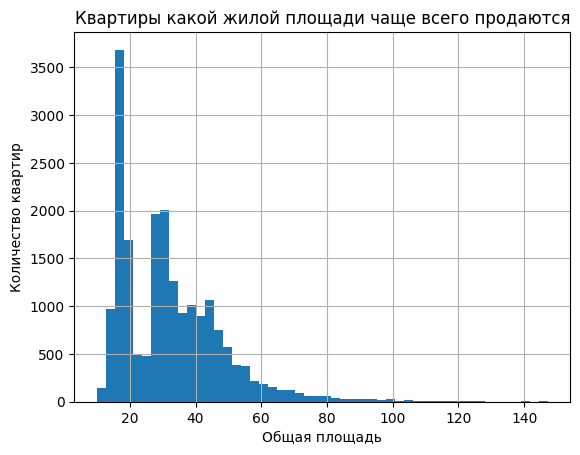

Медиана: 30.0


In [181]:
ax = df['living_area'].hist(bins = 50)
ax.set_xlabel("Общая площадь")
ax.set_ylabel("Количество квартир")
ax.set_title("Квартиры какой жилой площади чаще всего продаются")
plt.show()
print('Медиана:',df['living_area'].apply('median'))

Есть провал в интервале 20-30м. 
Получается есть группа квартир с очень маленькой площадью, их можно выделить в отдельную группу. 
При этом квартир от 20 до 26 метров очень мало

#### Площадь кухни

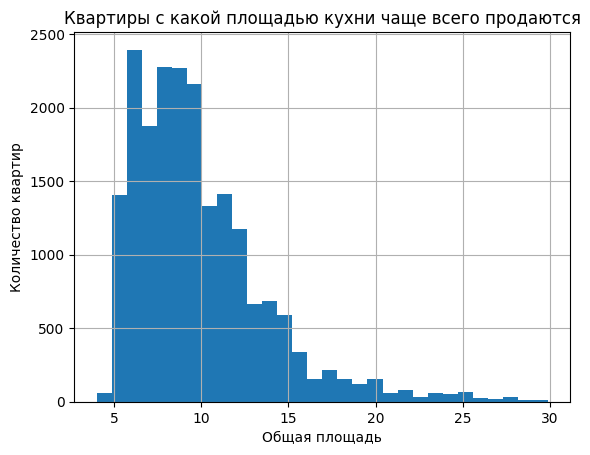

Медиана: 9.0


In [182]:
ax = df['kitchen_area'].hist(bins = 30)
ax.set_xlabel("Общая площадь")
ax.set_ylabel("Количество квартир")
ax.set_title("Квартиры с какой площадью кухни чаще всего продаются")
plt.show()
print('Медиана:',df['kitchen_area'].apply('median'))

Хорошее распределение. Чаще всего кухня в квартирах 9 метров

#### Количество комнат

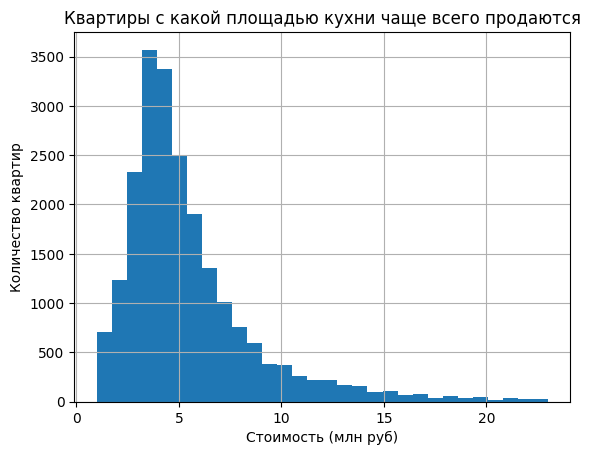

Медиана: 4600000.0


In [183]:
ax = (df['last_price']/1000000).hist(bins = 30)
ax.set_xlabel("Стоимость (млн руб)")
ax.set_ylabel("Количество квартир")
ax.set_title("Квартиры с какой площадью кухни чаще всего продаются")
plt.show()
print('Медиана:',df['last_price'].apply('median'))

Чаще всего продаются квартиры от 2.5 до 6 млн рублей.

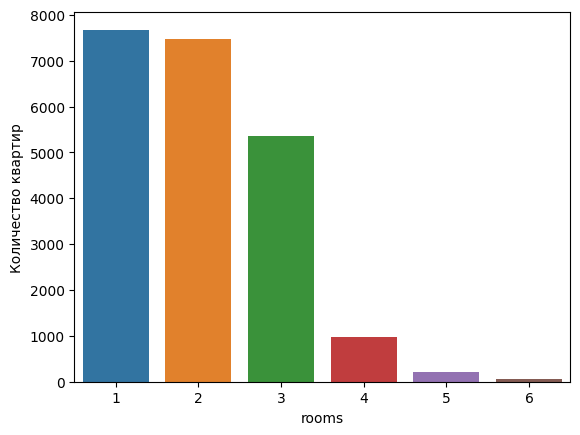

In [184]:
ax = df.groupby('rooms',as_index = False)['last_price'].count()
ax = sns.barplot(x=ax['rooms'], y = ax['last_price'])
ax.set_ylabel("Количество квартир")
plt.show()


Чаще всего покупают 1,2 комнатные квартиры, реже - трешки. 4,5 комнат покупают редко

#### Высота потолков

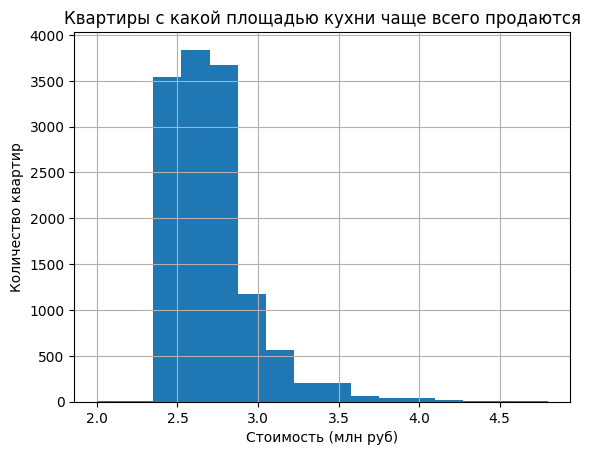

Медиана: 2.65


In [185]:
ax = (df['ceiling_height']).hist(bins = 16)
ax.set_xlabel("Стоимость (млн руб)")
ax.set_ylabel("Количество квартир")
ax.set_title("Квартиры с какой площадью кухни чаще всего продаются")
plt.show()
print('Медиана:',df['ceiling_height'].apply('median'))

Высота потолков кратна 10см, бывают промежуточные размеры, но реже.
Отдельно стоит выделить 3м, группа с высокими потолками (скорее всего премиум сегмент) Чаще всего покупают 2.5 2.6 2.7 2.8 и 3 м

#### Этаж

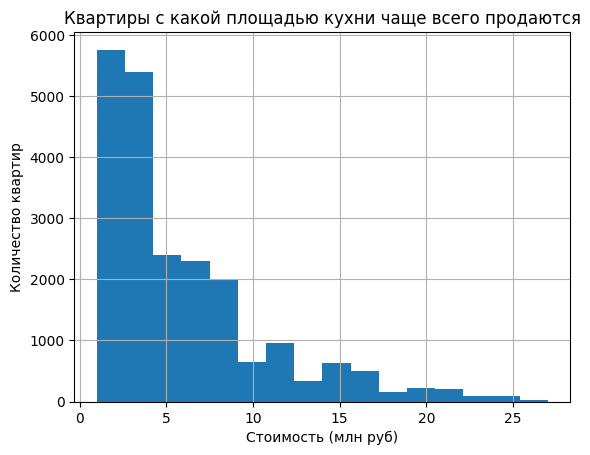

Медиана: 4.0


In [186]:
ax = (df['floor']).hist(bins = 16)
ax.set_xlabel("Стоимость (млн руб)")
ax.set_ylabel("Количество квартир")
ax.set_title("Квартиры с какой площадью кухни чаще всего продаются")
plt.show()
print('Медиана:',df['floor'].apply('median'))

Чаще всего покупают квартиры до 10 этажа, но здесь стоит оговориться, ведь во многих домах нет 10 и более этажей.

#### Тип этажа

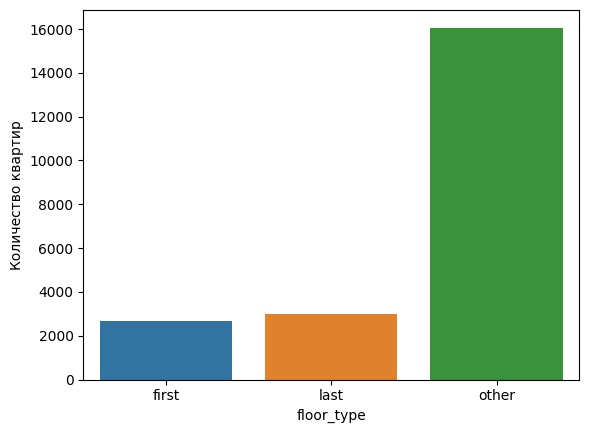

In [187]:
ax = df.groupby('floor_type',as_index = False)['last_price'].count()
ax = sns.barplot(x=ax['floor_type'], y = ax['last_price'])
ax.set_ylabel("Количество квартир")
plt.show()

Не удивительно, первых и последних этажей всегда меньше

#### Общее число этажей

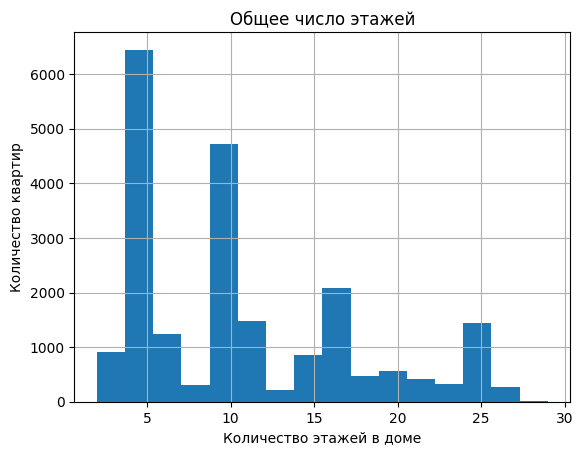

Медиана: 9.0


In [188]:
ax = (df['floors_total']).hist(bins = 16)
ax.set_xlabel("Количество этажей в доме")
ax.set_ylabel("Количество квартир")
ax.set_title("Общее число этажей")
plt.show()
print('Медиана:',df['floors_total'].apply('median'))

Чаще всего встречются дома, где количество картир кратно 5.
Остальные варианты встречаются гораздо реже.

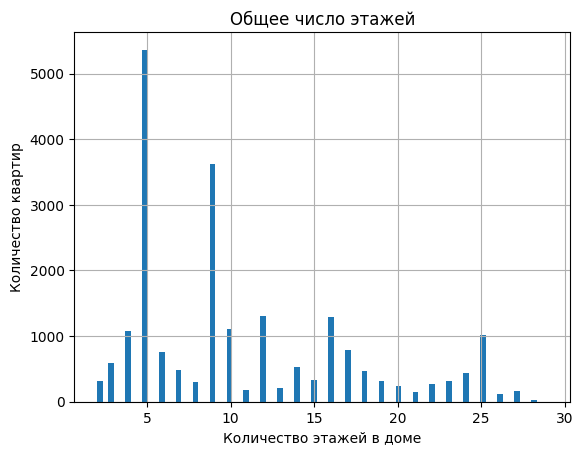

Медиана: 9.0


In [189]:
# check
ax = (df['floors_total']).hist(bins = 80)
ax.set_xlabel("Количество этажей в доме")
ax.set_ylabel("Количество квартир")
ax.set_title("Общее число этажей")
plt.show()
print('Медиана:',df['floors_total'].apply('median'))

#### Расстояние до центра города в метрах

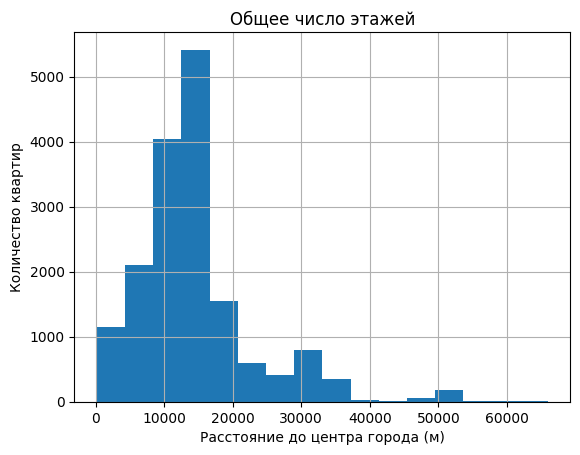

Медиана: 13285.0


In [190]:
ax = (df['cityCenters_nearest']).hist(bins = 16)
ax.set_xlabel("Расстояние до центра города (м)")
ax.set_ylabel("Количество квартир")
ax.set_title("Общее число этажей")
plt.show()
print('Медиана:',df['cityCenters_nearest'].apply('median'))

Основная часть квартир расположена ближе 20 км от центра города

#### Расстояние до ближайшего аэропорта

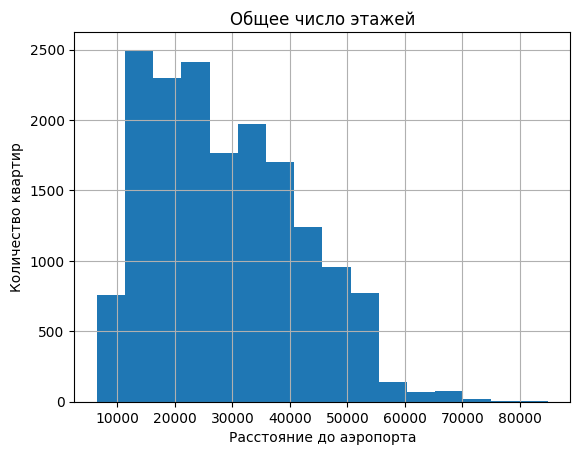

Медиана: 21709.0


In [191]:
ax = (df[df['airports_nearest']>0]['airports_nearest']).hist(bins = 16)
ax.set_xlabel("Расстояние до аэропорта")
ax.set_ylabel("Количество квартир")
ax.set_title("Общее число этажей")
plt.show()
print('Медиана:',df['airports_nearest'].apply('median'))

Т.к. количество объектов, где указано расстояние до аэропорта менее 5тысяч. Можно сделать вывод, что при наличии аэропорта дома стараются строить ближе к нему, но не ближе, чем 5км

#### Расстояние до парка

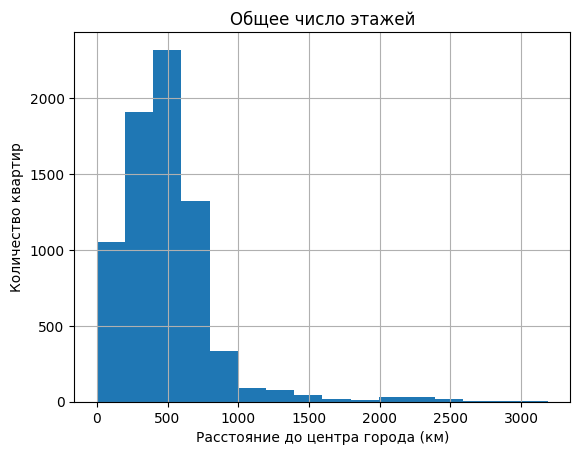

Медиана: 0.0


In [192]:
ax = (df[df['parks_nearest']>0]['parks_nearest']).hist(bins = 16)
ax.set_xlabel("Расстояние до центра города (км)")
ax.set_ylabel("Количество квартир")
ax.set_title("Общее число этажей")
plt.show()
print('Медиана:',df['parks_nearest'].apply('median'))

В случае наличия парка рядом. Основное число квартир на расстоянии 500 м от него

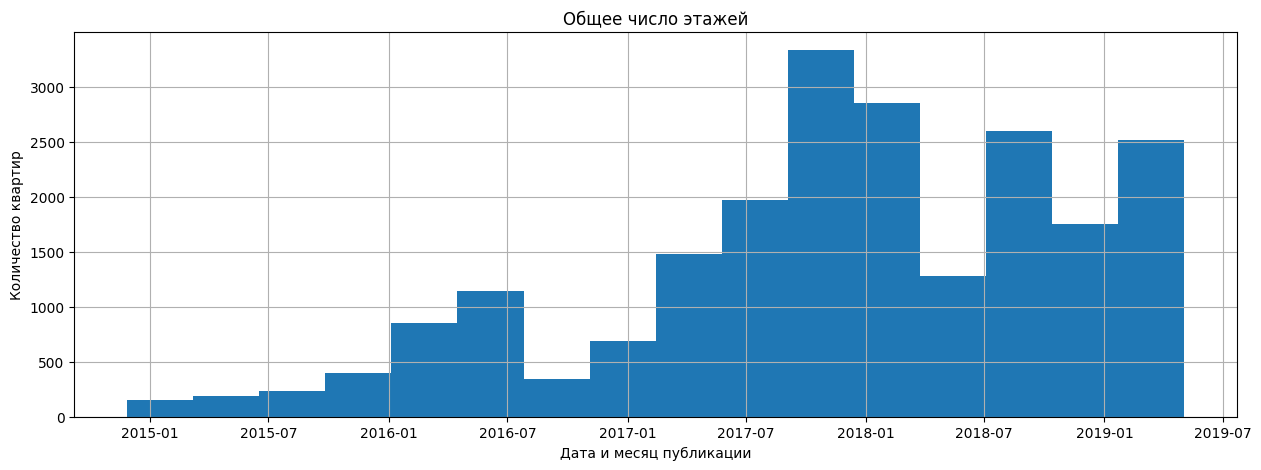

Медиана: 2017-12-17 00:00:00


In [193]:
ax = (df['first_day_exposition']).hist(bins = 16,figsize = (15,5))
ax.set_xlabel("Дата и месяц публикации")
ax.set_ylabel("Количество квартир")
ax.set_title("Общее число этажей")
plt.show()
print('Медиана:',df['first_day_exposition'].apply('median'))

Больше всего объявлений было сделано в 2017-2018 году. Потом был спад, но позже частота объявлений увеличилась

In [194]:
# Посчитаем коэффициенты корреляции
phik_overview = df[params].phik_matrix()
cor = pd.DataFrame(df[params].corr())
phik_overview['cor'] = cor['last_price']
phik_overview.loc[:,['last_price','cor']].sort_values('last_price',ascending = False)

interval columns not set, guessing: ['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area', 'kitchen_area', 'floor', 'floors_total']


,last_price,cor
last_price,1.000000,1.000000
total_area,0.750295,0.773663
living_area,0.676259,0.672773
kitchen_area,0.572554,0.559401
ceiling_height,0.516981,0.507742
rooms,0.445107,0.499832
floors_total,0.339420,0.107679
floor,0.193555,0.086499
days_exposition,0.117480,0.098441


* Самая высокая связь стоимости с площадью жилой, общей и кухни
* Количество комнат также оказывает сильное влияние
* Далее размер кухни
* Коэффициенты по остальным параметрам низки, но мы посмотрим детальнее

Проверим связи более детально:

### Анализ взаимосвязи параметров
#### Как быстро продавались квартиры

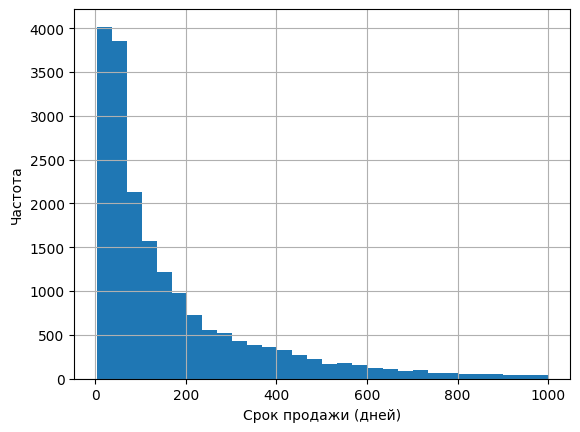

Медиана: 93
Среднее: 167


In [195]:
ax = df['days_exposition'].hist(bins = 30)
ax.set_ylabel('Частота')
ax.set_xlabel('Срок продажи (дней)')
plt.show()
print ('Медиана:', round(df['days_exposition'].median()))
print ('Среднее:', round(df['days_exposition'].mean()))

Чаще всего квартыры продаются быстрее 100 дней. Продажи больше года уже редкость.

#### Связь цены с другими параметрами
##### Цена и общая площадь

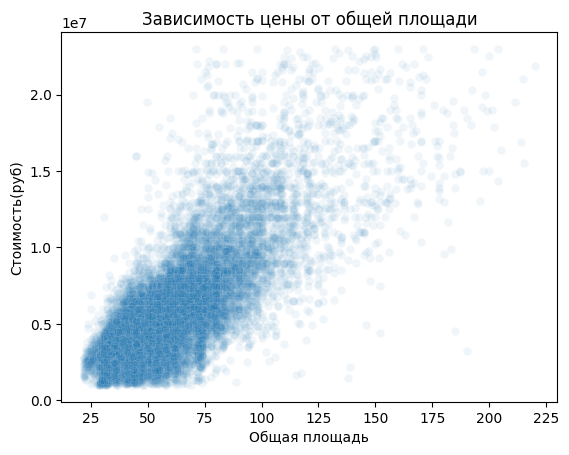

In [196]:
ax = sns.scatterplot(y=df['last_price'],x=df['total_area'],alpha = 0.07)
ax.set_ylabel('Стоимость(руб)')
ax.set_xlabel('Общая площадь')
ax.set_title('Зависимость цены от общей площади')
plt.show()

В целом наблюдается линейная корреляция. Чем выше жил площадь, тем выше цена.

##### Цена и жилая площадь

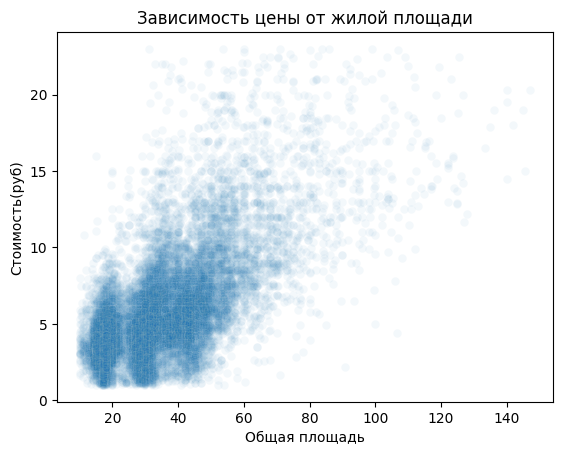

In [197]:
ax = sns.scatterplot(y=df['last_price']/1000000,x=df['living_area'],alpha = 0.05)
ax.set_ylabel('Стоимость(руб)')
ax.set_xlabel('Общая площадь')
ax.set_title('Зависимость цены от жилой площади')
plt.show()

Связь также сильная. Чем выше жил площадь, тем выше цена, но здесь не так линейно как в случае с общей площадью
##### Цена и площадь кухни

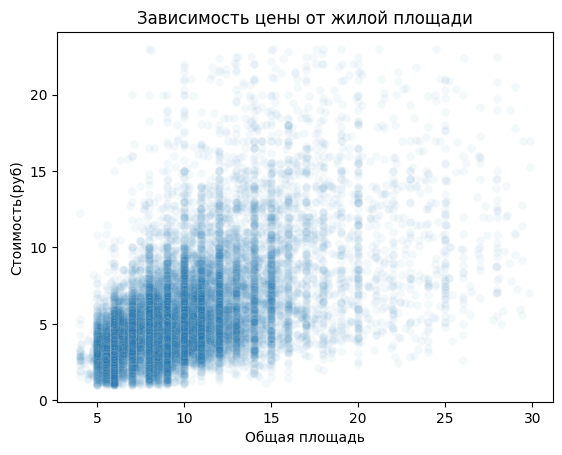

In [198]:
ax = sns.scatterplot(y=df['last_price']/1000000,x=df['kitchen_area'],alpha = 0.05)
ax.set_ylabel('Стоимость(руб)')
ax.set_xlabel('Общая площадь')
ax.set_title('Зависимость цены от жилой площади')
plt.show()

Связь также сильная. Чем выше площадь кухни, тем выше цена, но здесь не так линейно как в случае с общей площадью

##### Цена и количество комнат

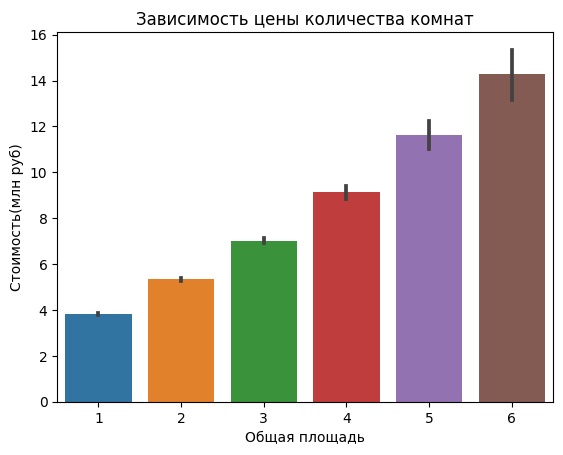

In [199]:
ax = sns.barplot(y=df['last_price']/1000000,x=df['rooms'])
ax.set_ylabel('Стоимость(млн руб)')
ax.set_xlabel('Общая площадь')
ax.set_title('Зависимость цены количества комнат')
plt.show()

Связь почти линейная. Чем больше комнат - тем выше цена

##### Цена и тип этажа

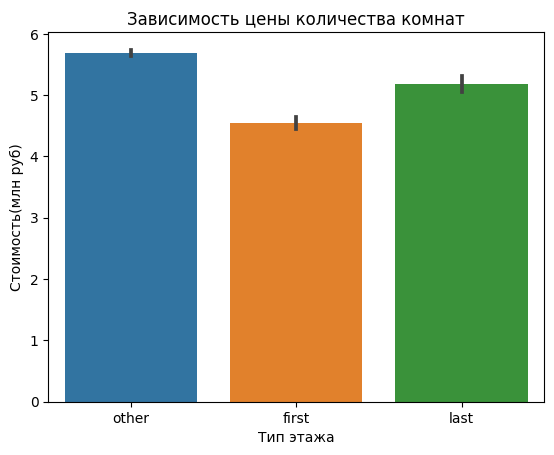

In [200]:
ax = sns.barplot(y=df['last_price']/1000000,x=df['floor_type'])
ax.set_ylabel('Стоимость(млн руб)')
ax.set_xlabel('Тип этажа')
ax.set_title('Зависимость цены количества комнат')
plt.show()

На первых и последних этажах цена ниже

##### Зависимость цены от даты размещения

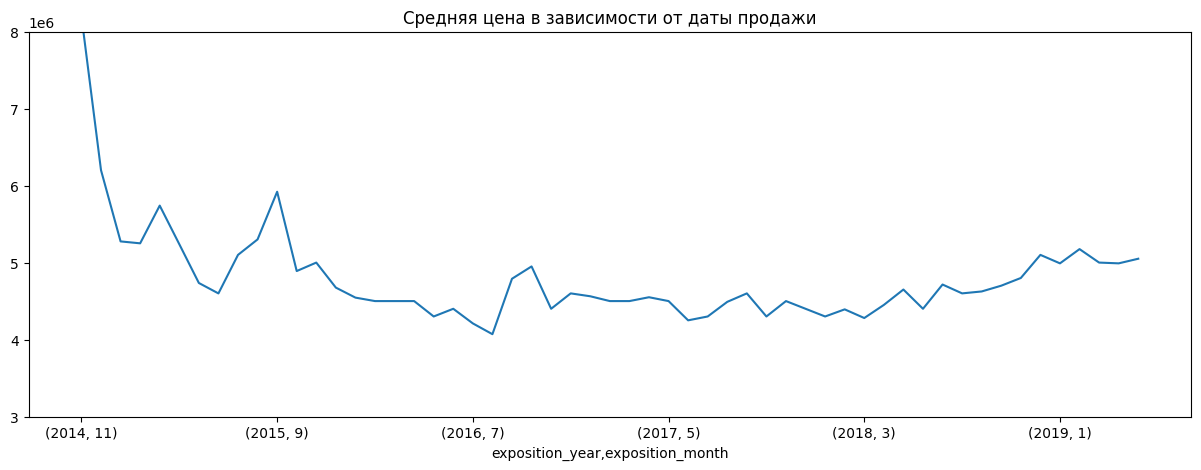

In [201]:
df.groupby(['exposition_year','exposition_month'])['last_price'].median().plot(ylim = (3000000, 8000000), figsize = (15,5))
plt.title('Средняя цена в зависимости от даты продажи')
plt.show()



Когда пользователи начали выкладывать объявления, были сильные колебания из-за небольшого количества данных.
С 2016 года цены растут

## Доп. задания
### Средняя цена объявлений в топ 10 городах

In [202]:
#Задание №3 "Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце `locality_name`.
top10 = df.groupby('short_locality_name')['price_1m'].agg(['count','mean']).sort_values('count',ascending=False).head(10)
top10.sort_values('mean',ascending=False)

,count,mean
short_locality_name,,
Санкт-Петербург,14363,108789.891686
Пушкин,345,101559.870660
Кудрово,438,95119.755444
Парголово,317,90308.105784
Мурино,540,85397.742965
Шушары,426,78354.075330
Колпино,331,75351.428477
Гатчина,301,68868.330781
Всеволожск,382,67149.554308


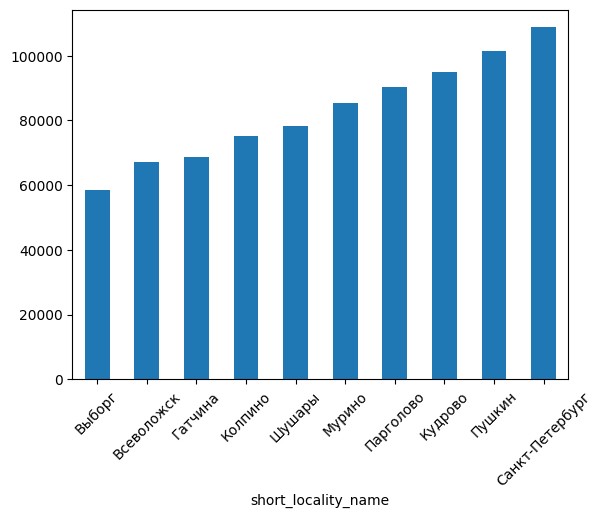

In [203]:
top10['mean'].sort_values().plot(kind = 'bar',rot = 45)
plt.show()

* Больше всего квартир по самой высокой стоимости в СПб. Средняя стоимость 1 квадратного метра составляет 110,7 тыс рублей.
* Самое доступное жилье в Выборге почти в 2 раза дешевле, чем в Санкт-Петербурге - 58.2 тыс рублей.

### Стоимость 1 км близости к центру города

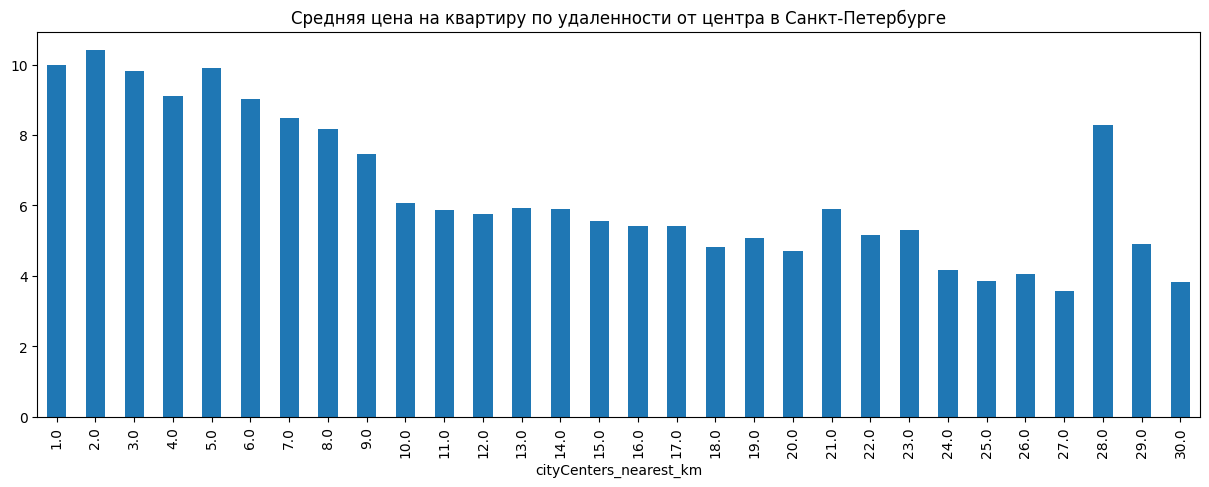

In [204]:
# Задание №4 выполнено задание: "Ранее вы посчитали расстояние до центра в километрах. 
# Теперь выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите среднюю цену каждого километра. 
# Опишите, как стоимость объектов зависит от расстояния до центра города."
df_good_spb = df.query('short_locality_name == "Санкт-Петербург"')
df_good_spb['last_price_million'] = df_good_spb['last_price']/1000000
df_good_spb.groupby('cityCenters_nearest_km')['last_price_million'].mean().plot(kind = 'bar', figsize = (15,5))
plt.title('Средняя цена на квартиру по удаленности от центра в Санкт-Петербурге')
plt.show()


На графике мы видим, что квартиры, расположенные на расстоянии 5 км от центра в среднем стоят в районе 10млн, когда у квартир, расплоложенных от 10 км цена на превосходит 6 млн

* Самая высокая цена метра у квартир, которые находятся на расстоянии менее 3 километров к центру города и составляет 5.6 млн рублей за квадратный метр.
* На расстоянии от 3 до 6 км стоимость падает более, чем в 2 раза и находится в районе 

# Общие выводы:
1. На стоимость квартиры больше всего влияют следующие параметры в порядке уменьшения веса:
   1. Общая площадь
   2. Жилая площадь (почти линейно коррелирует с общей площадью)
   3. Площадь кухни
   4. Расстояние до центра города
   5. Количество комнат
   6. Расстояние до аэропорта.

2. Дополнительные параметры, влияющие на стоимость:
   1. Первый и последний этажи стоят дешевле остальных
   2. День недели публикации объявления не влияет на стоимость, но влияет на срок продажи
   3. В 2014 году квартиры продовались дороже всего начиная с 2015 года цены существенно снизились 

Было установлено, что по небольшим городам данные не указаны. Детальная информация есть только по крупным городам.


**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод `info()`, гистограммы и т.д.)
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения там, где это возможно
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  устранены неявные дубликаты в названиях населённых пунктов
- [x]  устранены редкие и выбивающиеся значения (аномалии) во всех столбцах
- [x]  посчитано и добавлено в таблицу: цена одного квадратного метра
- [x]  посчитано и добавлено в таблицу: день публикации объявления (0 - понедельник, 1 - вторник и т.д.)
- [x]  посчитано и добавлено в таблицу: месяц публикации объявления
- [x]  посчитано и добавлено в таблицу: год публикации объявления
- [x]  посчитано и добавлено в таблицу: тип этажа квартиры (значения — «первый», «последний», «другой»)
- [x]  посчитано и добавлено в таблицу: расстояние в км до центра города
- [x]  изучены и описаны следующие параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - этаж квартиры;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего аэропорта;
        - расстояние до ближайшего парка;
        - день и месяц публикации объявления
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней «висело» каждое объявление.
    - Постройте гистограмму.
    - Посчитайте среднее и медиану.
    - В ячейке типа markdown опишите, сколько обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?"
- [x]  выполнено задание: "Какие факторы больше всего влияют на общую (полную) стоимость объекта? Постройте графики, которые покажут зависимость цены от указанных ниже параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы."
   x    - общей площади;
   x    - жилой площади;
   x    - площади кухни;
   x    - количество комнат;
   x    - типа этажа, на котором расположена квартира (первый, последний, другой);
   x    - даты размещения (день недели, месяц, год);
- [x]  выполнено задание: "Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце `locality_name`."
- [x]  выполнено задание: "Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города."
- [x]  в каждом этапе есть промежуточные выводы
- [x]  есть общий вывод